# <center>Regularization in Neural Network</center>
<center>Shan-Hung Wu & DataLab<br/>Fall 2016</center>

In [19]:
from IPython.display import Image
from IPython.display import display

# inline plotting instead of popping out
%matplotlib inline

# load utility classes/functions that has been taught in previous labs
# e.g., plot_decision_regions()
import os, sys
module_path = os.path.abspath(os.path.join('.'))
sys.path.append(module_path)
from lib import *

Deep neural network with a large number of parameters is a powerful machine learning system, but over-fitting is a serious issues in such networks. Deep neural network contains many non-linear hidden units and thus they can express very complicated relationships between their inputs and outputs. With limited training data, many of these relationships will be the result of sampling noise, so these relationships exist only on the training dataset, but not on the testing dataset. Large networks are slow, so it's hard for us to deal with the over-fitting issues by training several networks with different architecture and combine their outputs.
In this lab, we are going to talk about regularization in neural network.
We will introduce some common regularization methods in deep neural network today, which is 
* Dropout
* Weight decay
* Weight constraint
* Batch Normalization
* Data augmentation

We use the CIFAR-10 dataset for our experiment. [CIFAR-10]() is a object recognition dataset of 10 class. The CIFAR-10 dataset consists of 60000 32x32 color images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 


The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. 

Here are the classes in the dataset, as well as 10 random images from each:
<img src="fig-cifar-10.png" width="400">



# Loading and Preprocess the CIFAR-10 Dataset

## Load Data
Set the path for storing the dataset on your machine.

In [20]:
import os
import numpy as np
import sys
import tarfile
import urllib.request
import pickle
import _pickle as cPickle
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from os.path import expanduser
home = expanduser('~')
data_path = os.path.join(home, "data/CIFAR-10/")

Set the constants for processing the dataset.

In [21]:
img_size = 32
img_channels = 3
nb_classes = 10
# length of the image after we flatten the image into a 1-dim array
img_size_flat = img_size * img_size * img_channels
nb_files_train = 5
images_per_file = 10000
# number of all the images in the training dataset
nb_images_train = nb_files_train * images_per_file


This is the code for downloading and extracting the cifar dataset from the internet

In [22]:
def download_and_extract_cifar():
    filename = 'cifar-10-batches-py/'
    file_path = os.path.join(data_path, filename)

    # if the file exists then we assume it has also been extracted,
    # otherwise we need to download and extract it.
    if not os.path.exists(file_path):
        # check if the download directory exists, otherwise create it.
        if not os.path.exists(data_path):
            os.makedirs(data_path)

        file_path, _ = urllib.request.urlretrieve(url=data_url,
                                                  filename=os.path.join(data_path, 'cifar-10-python.tar.gz'),
                                                  reporthook=_print_download_progress)
        print("Download finished. Extracting files.")

        if file_path.endswith(".zip"):
            zipfile.ZipFile(file=file_path, mode="r").extractall(data_path)
        elif file_path.endswith((".tar.gz", ".tgz")):
            tarfile.open(name=file_path, mode="r:gz").extractall(data_path)

        print("Done.")
    else:
        print("Data has already been downloaded and unpacked.")

In [23]:
def load_cifar():
    
    def load_data(file_name):

        file_path = os.path.join(data_path, "cifar-10-batches-py/", file_name)
        print("Loading data: " + file_path)
        with open(file_path, mode='rb') as file:    
            data = pickle.load(file, encoding='bytes')
        raw_images = data[b'data']
        cls = np.array(data[b'labels'])
        # convert the raw images from the data-files to floating-points.
        raw_float = np.array(raw_images, dtype=float) / 255.0
        # reshape the array to a 4-dim array with shape: [image_number, channel, height, width] where the pixels are floats between 0.0 and 1.0.
        images = raw_float.reshape([-1, img_channels, img_size, img_size])
        return images, cls

    def load_training_data():
        
        # pre-allocate the arrays for the images and class-numbers for efficiency.
        images = np.zeros(shape=[nb_images_train, img_channels, img_size, img_size], dtype=float)
        cls = np.zeros(shape=[nb_images_train], dtype=int)
        begin = 0
        for i in range(nb_files_train):

            images_batch, cls_batch = load_data(file_name="data_batch_" + str(i + 1))
            num_images = len(images_batch)
            end = begin + num_images
            images[begin:end, :] = images_batch
            cls[begin:end] = cls_batch
            begin = end

        return images, cls, np_utils.to_categorical(cls, nb_classes)

    def load_test_data():

        images, cls = load_data(file_name="test_batch")
        return images, cls, np_utils.to_categorical(cls, nb_classes)
    
    download_and_extract_cifar()
    X_train, cls_train, y_train = load_training_data()
    X_test, cls_test, y_test = load_test_data()
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [24]:
X_train, X_valid, X_test, y_train, y_valid, y_test = load_cifar()

Data has already been downloaded and unpacked.
Loading data: /home/admin0/data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: /home/admin0/data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: /home/admin0/data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: /home/admin0/data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: /home/admin0/data/CIFAR-10/cifar-10-batches-py/data_batch_5
Loading data: /home/admin0/data/CIFAR-10/cifar-10-batches-py/test_batch


Print out the size of the training and testing set to check if everything is loaded correctly.

In [7]:
# check data
print("Size of:")
print("- Training-set:\t\t{}".format(len(X_train)))
print("- Validation-set:\t{}".format(len(X_valid)))
print("- Test-set:\t\t{}".format(len(X_test)))

Size of:
- Training-set:		40000
- Validation-set:	10000
- Test-set:		10000


Then we convert the images into grey-scale

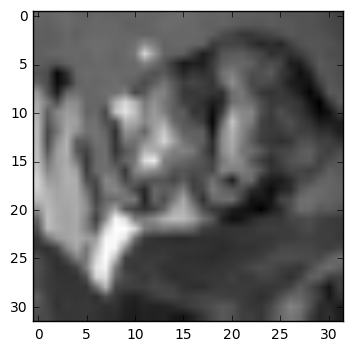

In [27]:
import matplotlib.pyplot as pyplot
def _grayscale(data, dtype='float32'):
    # we use the luma coding weighted average in video systems here (https://en.wikipedia.org/wiki/Grayscale)
    r, g, b = np.asarray(.3,dtype=dtype), np.asarray(.59,dtype=dtype), np.asarray(.11,dtype=dtype)
    rst = r*data[:,0,:, :] + g*data[:, 1, :, :] + b*data[:, 2, :, :]
    # plot out image
    pyplot.imshow(rst[0], cmap=pyplot.get_cmap('gray'))
    # add dummy axis to make single image from size (32, 32) to (1, 32 ,32)
    rst = np.expand_dims(rst, axis=1)
    # return rst.reshape((-1,1,32,32))
    return rst


X_train_grey = _grayscale(X_train)
X_valid_grey = _grayscale(X_valid)
X_test_grey = _grayscale(X_test)
# now we have only one channel in the images
img_channels = 1

Print out the size of each dimension of the training data[image_number, channel, height, width], since we convert the image from color to grey scale, the channel is reduced to 1

In [9]:
print(np.shape(X_train_grey))

(40000, 1, 32, 32)


Let's use a deep model as our base model to deal with the task today.

In [10]:
# here are some settings for the network experiment
batch_size = 32
nb_epoch = 50
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0)

CPU times: user 1min 7s, sys: 6.49 s, total: 1min 14s
Wall time: 1min 14s
Test loss: 1.760
Test accuracy: 0.385


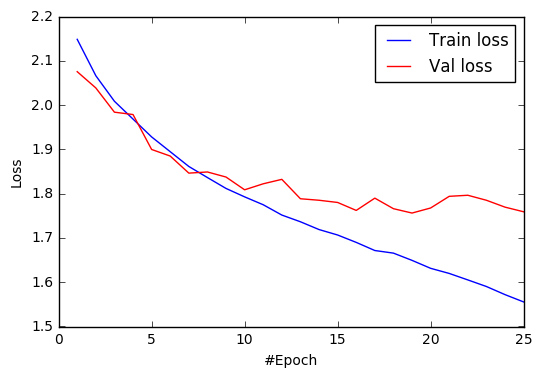

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, GaussianNoise, MaxoutDense
from keras.constraints import maxnorm
from keras.regularizers import l1, l2
from keras.optimizers import SGD
import matplotlib.pyplot as plt
import sys
import os
import time

model = Sequential()
# flatten our input into a single dimension array
model.add(Flatten(input_shape=(img_channels, img_size, img_size)))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))

# output layer
model.add(Dense(nb_classes, activation='softmax'))

# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

start = time.time()
%time his = model.fit(X_train_grey, y_train, \
          batch_size=batch_size, \
          nb_epoch=50, \
          validation_data=(X_valid_grey, y_valid), \
          callbacks=[early_stop], \
          verbose=0, \
          shuffle=True) \

# evaluate our model
score = model.evaluate(X_test_grey, y_test, verbose=0)
print('Test loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
plot_validation_history(his, './output/fig-vanilla-val-baseline.png')

We can also try to use a structure they gradually decrease the number of neurons as the number of layer increases. The deeper layers will serve a funciton of embedding of the shallow layers' outputs.

CPU times: user 46.3 s, sys: 1.62 s, total: 47.9 s
Wall time: 47.9 s
Test loss: 1.767
Test accuracy: 0.390


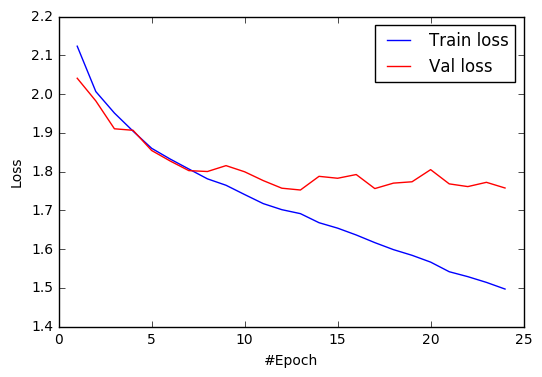

In [28]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, GaussianNoise, MaxoutDense
from keras.constraints import maxnorm
from keras.regularizers import l1, l2
from keras.optimizers import SGD
import matplotlib.pyplot as plt
import sys
import os
import time

model = Sequential()
# flatten our input into a single dimension array
model.add(Flatten(input_shape=(img_channels, img_size, img_size)))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))

# output layer
model.add(Dense(nb_classes, activation='softmax'))

# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

start = time.time()
%time his = model.fit(X_train_grey, y_train, \
          batch_size=batch_size, \
          nb_epoch=50, \
          validation_data=(X_valid_grey, y_valid), \
          callbacks=[early_stop], \
          verbose=0, \
          shuffle=True) \

# evaluate our model
score = model.evaluate(X_test_grey, y_test, verbose=0)
print('Test loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
plot_validation_history(his, './output/fig-vanilla-val-baseline.png')

Apparently we are having the issues of over fitting here. It's a chance for us to learn some regularizations technique.

# Dropout
Dropout is designed by Geoffrey Hinton.
The key idea is to randomly drop some units from the neural network during training, so that the neuron have to function well on its own instead of relying on other neurons. (Just like when you know your teammate is not that reliable, you have to take more responsibility)
In a standard neural network, the derivative received by each parameter tells it how it should change so the final loss function is reduced, given what all other units are doing. Therefore, units may change in a way that they fix up the mistakes of the other units. This may lead to complex co-adaptations.
Applying dropout to a neural network amounts to sampling a “thinned” network from it. The thinned network consists of all the units that are not dropped out (Figure b). A neural net with $n$ units, can be seen as a collection of  possible thinned neural networks. For each presentation of each training case, a new thinned network is sampled and trained.

The following figures illustrate the architecture:

<img src="fig-dropout.png" width="600">
<img src="fig-ensemble-of-subnetworks.png" width="600">


The choice of which units to drop is random. In the simplest case, each unit is retained with a fixed probability $p$ independent of other units, where $p$ can be chosen using a validation set or can simply be set at 0.5, which seems to be close to optimal for a wide range of networks and tasks.
At test time, it is not feasible to explicitly average the predictions from exponentially many thinned models. A very simple approximate averaging method works well in practice. The idea is to use a single neural net at test time **without dropout**. If a unit is retained with probability $p$ during training, the outgoing weights of that unit are multiplied by $p$ at test time as shown in the figure below. This is to ensure that for any hidden unit the expected output (under the distribution used to drop units at training time) is the same as the actual output at test time.
<img src="fig-weight.png" width="600">

Let's wrap our code into a function with several kinds of regularization options over our base model. Don't worry if you can't figure some of the code here, we will come back later.

In [57]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, GaussianNoise, MaxoutDense
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.constraints import maxnorm
from keras.regularizers import l1, l2
from keras.optimizers import SGD, Adam
import matplotlib.pyplot as plt
import sys
import os
import time

# monitor the validation loss
# min_delta : minimum change in the monitored quantity to qualify as an improvement
# patience : number of epochs with no improvement after which training will be stopped
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0)

def gen_nn(nb_layers=8, nb_neurons=512, dropout=False, weight_constraint=False, l2_reg=False, l2_coef=0.1, batch_normalization=False, adam=False, learning_rate=0.001, decay=True, clip_norm=False, clip_value=1.0):
    """
    Create a model according to the specification.
    """  
    
    model = Sequential()
    model.add(Flatten(input_shape=(img_channels, img_size, img_size)))
    
    for i in (0, nb_layers):
        
        # we can think of this chunk as a hidden layer  
        if l2_reg:
            model.add(Dense(nb_neurons, W_regularizer=l2(l2_coef))) 
        elif weight_constraint:
            model.add(Dense(nb_neurons, W_constraint=maxnorm(3)))            
        else:
            model.add(Dense(nb_neurons))

        if batch_normalization:
            model.add(BatchNormalization(mode=0, axis=1, beta_init='zero', gamma_init='one'))
        # add dropout after every two layers with dropout rate 0.25
        if dropout and i%2==0:
            model.add(Dropout(0.25))
            
        model.add(Activation('relu'))
        # end of a hidden layer       

    model.add(Dense(nb_classes, activation='softmax'))

    if decay:
        decay = learning_rate/nb_epoch
    else:
        # decay rate = 0.0 indicates no decay
        decay = 0.0
    
    if adam:
        # besides using the default 'adam' optimizer in the base model, you can customize the optimizer
        if clip_norm:
            adam = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=decay, clipnorm=clip_value)
        else:
            adam = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=decay)        
        model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    else:
        sgd = SGD(lr=0.01, momentum=0.9, decay=0.01/nb_epoch, nesterov=False)
        model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

CPU times: user 2min 8s, sys: 5.9 s, total: 2min 14s
Wall time: 2min 14s

Test loss: 1.668
Test accuracy: 0.413


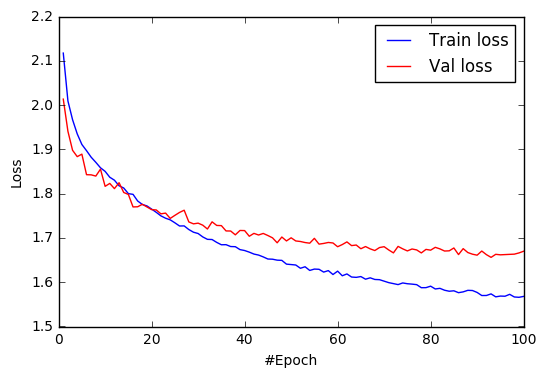

In [90]:
dropout_model = gen_nn(dropout=True, adam=True)

%time dropout_his = dropout_model.fit(X_train_grey, y_train, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_data=(X_valid_grey, y_valid), \
          callbacks=[early_stop], \
          verbose=0, \
          shuffle=True) \

# evaluate our model
score = dropout_model.evaluate(X_test_grey, y_test, verbose=0)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
plot_validation_history(dropout_his , './output/fig-nn-val-dropout-adam.png')

We can see the dropout has a signifanct effect on the result!

# Weight Decay
If you recall we talked about weight decay before. We can penalize large weights using penalties or constraints on their squared values (L2 penalty).
We specify a l2 regularities by passing a regularizer and its coefficients to the layer.
```
from keras.regularizers import l1, l2 
model.add(Dense(64, input_dim=64, W_regularizer=l2(0.01)))
```


## L2 Regularizer

This can often improve generalization a lot because it helps to stop the network from fitting the sampling error and it makes a smoother model in which the output changes more slowly as the input changes.

We can gain some insight into the behavior of weight decay regularization by studying the gradient of the regularized objective function. To simplify the presentation, we assume no bias parameter. Such a model has the following total objective function:

$$\tilde{C}(\mathbf{w};\mathbf{X},\mathbf{y})==\frac{\alpha}{2}\mathbf{w}^{T}\mathbf{w}+C(\mathbf{w};\mathbf{X},\mathbf{y}),$$

with the corresponding parameter gradient

$$\text{∇}_{\mathbf{w}}\tilde{C}(\mathbf{w};\mathbf{X},\mathbf{y})=α\mathbf{w}+\text{∇}_{\mathbf{w}}C(\mathbf{w};\mathbf{X},\mathbf{y}).$$

To take a single gradient step to update the weights, we perform this update:

$$\mathbf{w}←\mathbf{w}−(α\mathbf{w}+∇_{\mathbf{w}}C(\mathbf{w};\mathbf{X},\mathbf{y})).$$

Written another way, the update is: 

$$\mathbf{w}←(1−α)\mathbf{w}−∇_{\mathbf{w}}C(\mathbf{w};\mathbf{X},\mathbf{y})\Theta$$

We can see that the addition of the weight decay term has modiﬁed the learning
rule to multiplicatively shrink the weight vector by a constant factor on each step,
just before performing the usual gradient update.

CPU times: user 1min 54s, sys: 19.3 s, total: 2min 13s
Wall time: 2min 13s

Test loss: 1.720
Test accuracy: 0.389


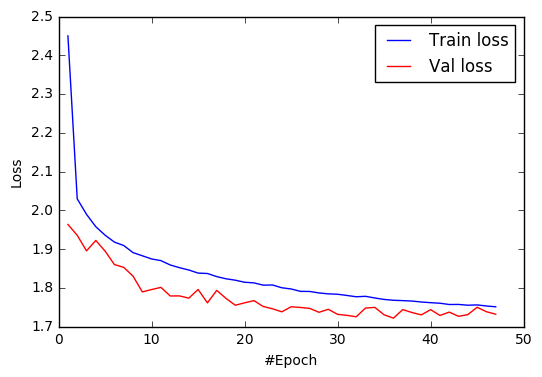

In [96]:
# l2_coef corresponds to the alpha in the formula above
l2_model = gen_nn(l2_reg=True, l2_coef=0.005, adam=True)
%time l2_his = l2_model.fit(X_train_grey, y_train, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_data=(X_valid_grey, y_valid), \
          callbacks=[early_stop], \
          verbose=0, \
          shuffle=True) \

# evaluate our model
score = l2_model.evaluate(X_test_grey, y_test, verbose=0)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
plot_validation_history(l2_his, './output/fig-nn-val-l2.png')

# Weight Constraint
We can also add weight constraint to constrain the norm of weight on a layer by passing W_constraint to the layer
```
from keras.constraints import maxnorm
model.add(Dense(1024, W_constraint = maxnorm(3)))
```


CPU times: user 45 s, sys: 2.4 s, total: 47.4 s
Wall time: 47.3 s

Test loss: 1.680
Test accuracy: 0.431


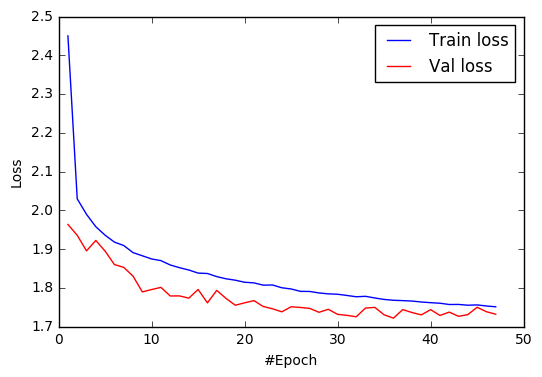

In [99]:
# weight constraint with Adam and decay learning rate
weight_constraint_model = gen_nn(weight_constraint=True, adam=True)
%time weight_constraint_his = weight_constraint_model.fit(X_train_grey, y_train, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_data=(X_valid_grey, y_valid), \
          callbacks=[early_stop], \
          verbose=0, \
          shuffle=True) \

# evaluate our model
score = weight_constraint_model.evaluate(X_test_grey, y_test, verbose=0)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
plot_validation_history(l2_his, './output/fig-nn-val-weight-constraint.png')

Compared to weight decay, weight constraint won't affect the learning when the norm of weight is not over the indeicated max norm.

# Batch Normalization
Batch Normalization is to explicitly forcing the activations throughout a network to take on a unit gaussian distribution. The core observation is that this is possible because normalization is a simple differentiable operation. In the implementation, insert the BatchNorm layer immediately after fully connected layers and **before** non-linearities.

keras have implemented Batch Normalization for you.
```
keras.layers.normalization.BatchNormalization(mode=0, axis=1, momentum=0.99, beta_init='zero', gamma_init='one')
```

- mode: integer, 0, 1 or 2.

    - 0: feature-wise normalization. Each feature map in the input will be normalized separately. The axis on which to normalize is specified by the axis argument. Note that if the input is a 4D image tensor using Theano conventions (samples, channels, rows, cols) then you should set axis to 1 to normalize along the channels axis. During training we use per-batch statistics to normalize the data, and during testing we use running averages computed during the training phase.
    - 1: sample-wise normalization. This mode assumes a 2D input.
    - 2: feature-wise normalization, like mode 0, but using per-batch statistics to normalize the data during both testing and training.
    
- axis: integer, axis along which to normalize in mode 0.




CPU times: user 38.9 s, sys: 854 ms, total: 39.8 s
Wall time: 39.8 s

Test loss: 2.488
Test accuracy: 0.370


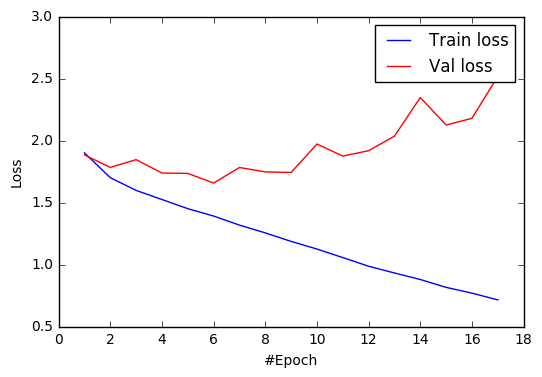

In [32]:
# batch normalization with Adam with decay learning rate
batch_norm_model = gen_nn(batch_normalization=True, adam=True)
%time batch_norm_his = batch_norm_model.fit(X_train_grey, y_train, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_data=(X_valid_grey, y_valid), \
          callbacks=[early_stop], \
          verbose=0, \
          shuffle=True) \
# evaluate our model
score = batch_norm_model.evaluate(X_test_grey, y_test, verbose=0)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
plot_validation_history(batch_norm_his, './output/fig-nn-val-batch-norm.png')

From the validation plot we can see that it's over fitting in the end. We can prevent the gradient from exploding by 
cliping a gradient if it exceeds a predefined threshold

CPU times: user 57.1 s, sys: 4.32 s, total: 1min 1s
Wall time: 1min 1s

Test loss: 2.330
Test accuracy: 0.400


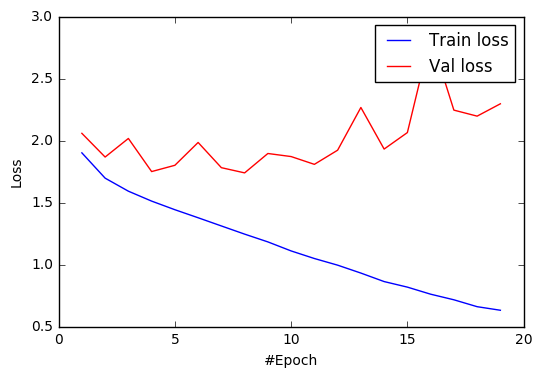

In [61]:
# batch normalization with Adam and gradient clipping, clip_value = 3
batch_norm_model = gen_nn(batch_normalization=True, adam=True, clip_norm=True, clip_value=3)
%time batch_norm_his = batch_norm_model.fit(X_train_grey, y_train, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_data=(X_valid_grey, y_valid), \
          callbacks=[early_stop], \
          verbose=0, \
          shuffle=True) \
# evaluate our model
score = batch_norm_model.evaluate(X_test_grey, y_test, verbose=0)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
plot_validation_history(batch_norm_his, './output/fig-nn-val-batch-norm.png')

CPU times: user 45.5 s, sys: 3.32 s, total: 48.8 s
Wall time: 48.8 s

Test loss: 2.104
Test accuracy: 0.393


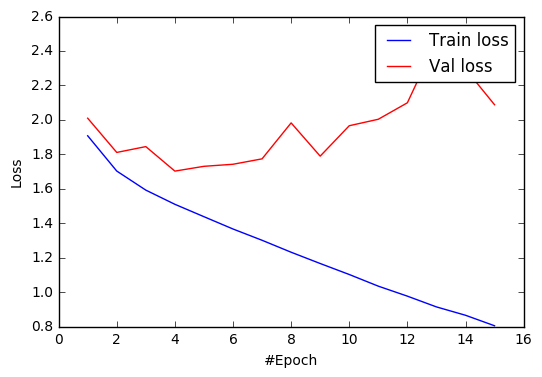

In [59]:
# batch normalization with Adam and gradient clipping, clip_value = 1
batch_norm_model = gen_nn(batch_normalization=True, adam=True, clip_norm=True, clip_value=1)
%time batch_norm_his = batch_norm_model.fit(X_train_grey, y_train, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_data=(X_valid_grey, y_valid), \
          callbacks=[early_stop], \
          verbose=0, \
          shuffle=True) \
# evaluate our model
score = batch_norm_model.evaluate(X_test_grey, y_test, verbose=0)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
plot_validation_history(batch_norm_his, './output/fig-nn-val-batch-norm.png')

CPU times: user 52.2 s, sys: 3.74 s, total: 55.9 s
Wall time: 55.9 s

Test loss: 2.293
Test accuracy: 0.405


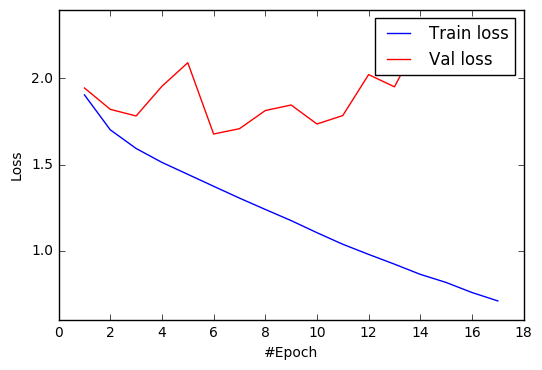

In [33]:
# batch normalization with Adam and gradient clipping
batch_norm_model = gen_nn(batch_normalization=True, adam=True, clip_norm=True)
%time batch_norm_his = batch_norm_model.fit(X_train_grey, y_train, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_data=(X_valid_grey, y_valid), \
          callbacks=[early_stop], \
          verbose=0, \
          shuffle=True) \
# evaluate our model
score = batch_norm_model.evaluate(X_test_grey, y_test, verbose=0)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
plot_validation_history(batch_norm_his, './output/fig-nn-val-batch-norm.png')

CPU times: user 52.2 s, sys: 3.85 s, total: 56.1 s
Wall time: 56.1 s

Test loss: 2.375
Test accuracy: 0.400


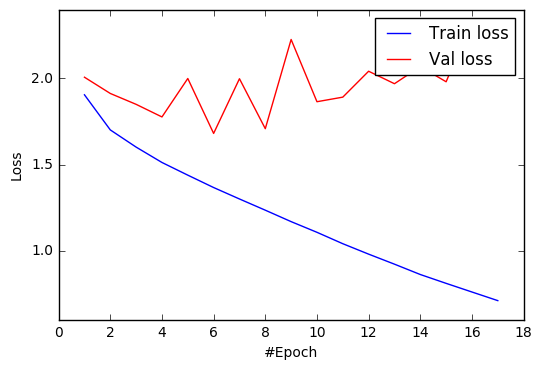

In [55]:
nb_epoch=50
# batch normalization with Adam and gradient clipping, clip norm = 0.005
batch_norm_model = gen_nn(batch_normalization=True, adam=True, clip_norm=True)
%time batch_norm_his = batch_norm_model.fit(X_train_grey, y_train, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_data=(X_valid_grey, y_valid), \
          callbacks=[early_stop], \
          verbose=0, \
          shuffle=True) \
# evaluate our model
score = batch_norm_model.evaluate(X_test_grey, y_test, verbose=0)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
plot_validation_history(batch_norm_his, './output/fig-nn-val-batch-norm.png')

CPU times: user 57.8 s, sys: 4.22 s, total: 1min 1s
Wall time: 1min 1s

Test loss: 2.516
Test accuracy: 0.370


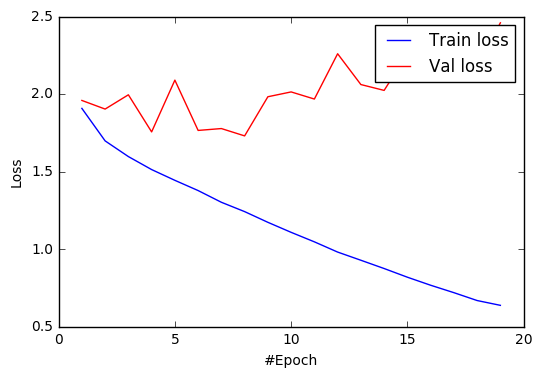

In [60]:
nb_epoch=50
# batch normalization with Adam and gradient clipping, clip norm = 0.005
batch_norm_model = gen_nn(batch_normalization=True, adam=True, clip_norm=True, clip_value=0.001)
%time batch_norm_his = batch_norm_model.fit(X_train_grey, y_train, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_data=(X_valid_grey, y_valid), \
          callbacks=[early_stop], \
          verbose=0, \
          shuffle=True) \
# evaluate our model
score = batch_norm_model.evaluate(X_test_grey, y_test, verbose=0)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
plot_validation_history(batch_norm_his, './output/fig-nn-val-batch-norm.png')

The test accuracy did improve, but he validation loss keep buncing around at the end. We can try to use a smaller learning rate from 0.001 to 0.0001

CPU times: user 50.7 s, sys: 1.78 s, total: 52.5 s
Wall time: 52.5 s

Test loss: 1.735
Test accuracy: 0.439


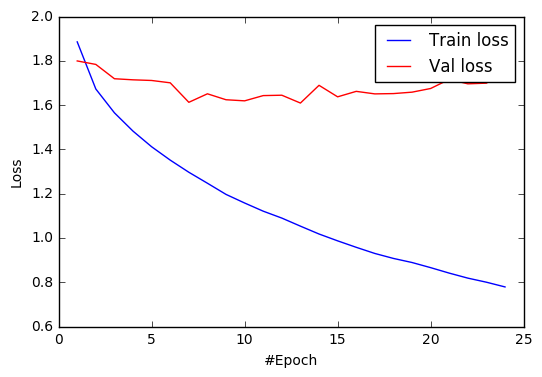

In [109]:
# batch normalization with Adam and decay learning rate
batch_norm_model = gen_nn(batch_normalization=True, adam=True, learning_rate=0.0001)
%time batch_norm_his = batch_norm_model.fit(X_train_grey, y_train, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_data=(X_valid_grey, y_valid), \
          callbacks=[early_stop], \
          verbose=0, \
          shuffle=True) \
# evaluate our model
score = batch_norm_model.evaluate(X_test_grey, y_test, verbose=0)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
plot_validation_history(batch_norm_his, './output/fig-nn-val-batch-norm.png')

The test accuracy improves!

# Data Augmentation
We will "augment" the data via a number of random transformations, so that our model would never see twice the exact same picture. This helps prevent overfitting and helps the model generalize better. (For the model, that's like it can see ore data than before!) This skill is very useful especially when you have very little amount of data.
* rotation_range is a value in degrees (0-180), a range within which to randomly rotate pictures
* width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally
* shear_range is for randomly applying shearing transformations
* zoom_range is for randomly zooming inside pictures
* horizontal_flip is for randomly flipping half of the images horizontally --relevant when there are no assumptions of horizontal assymetry (e.g. real-world pictures).
* fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

** caution: do not do transformation that's going to affect the label. For example, if you do a hirizontal flipp on 'b', it will become 'd' **

Below we visualize some images after augmentation.

Remember to set `"image_dim_ordering": "th"` in your `~/.keras/keras.json` file. 
For 2D data (e.g. image), `"tf"` assumes `(rows, cols, channels)` while `"th"` assumes `(channels, rows, cols)`.
You might have to restart your jupyter notebook after this.

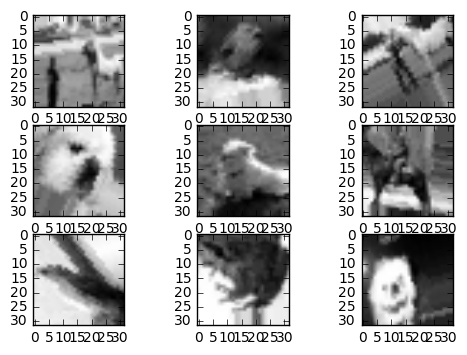

In [34]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as pyplot

datagen = ImageDataGenerator(
        rotation_range=40, \
        width_shift_range=0.2, \
        height_shift_range=0.2, \
        shear_range=0.2, \
        zoom_range=0.2, \
        horizontal_flip=True, \
        fill_mode='nearest')

# visualize some examples after augmentation
for X_batch, y_batch in datagen.flow(X_train_grey, y_train, batch_size=9):
    # create a grid of 3x3 images
    for i in range(0, 9):
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(X_batch[i, 0], cmap=pyplot.get_cmap('gray'))
    # show the plot
    pyplot.show()
    break

CPU times: user 5min 7s, sys: 9.22 s, total: 5min 16s
Wall time: 4min 47s

Test loss: 1.672
Test accuracy: 0.407


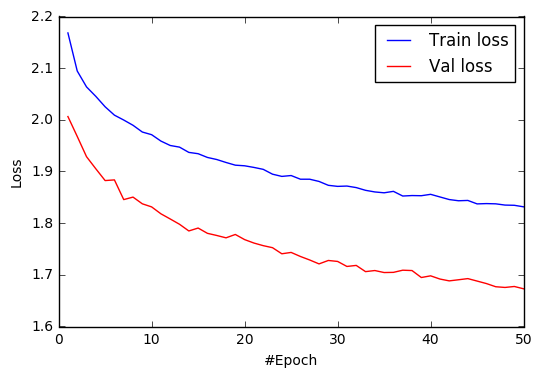

In [124]:
# data augmentation with SGD and decay learning rate. (SGD works better in this case)
base_model = gen_nn(adam=False)    
start = time.time()
%time aug_his = base_model.fit_generator(datagen.flow(X_train_grey, y_train, \
                    batch_size=batch_size), \
                    samples_per_epoch=X_train.shape[0], \
                    nb_epoch=nb_epoch, \
                    callbacks=[early_stop], \
                    verbose=0, \
                    validation_data=(X_valid_grey, y_valid))
# evaluate our model
score = base_model.evaluate(X_test_grey, y_test, verbose=0)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
plot_validation_history(aug_his, './output/fig-nn-val-aug.png')

CPU times: user 10min 20s, sys: 17.9 s, total: 10min 38s
Wall time: 9min 41s

Test loss: 1.622
Test accuracy: 0.431


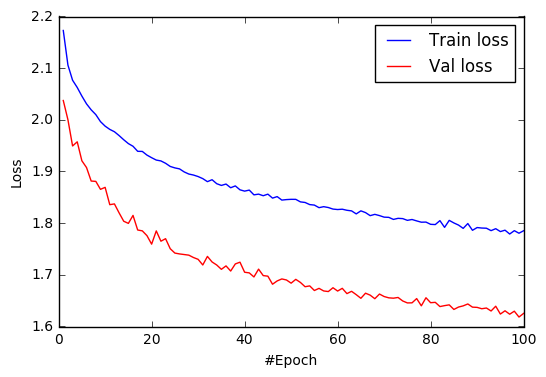

In [43]:
# data augmentation with SGD and decay learning rate. (SGD works better in this case)
nb_epoch=100
base_model = gen_nn(adam=False)    
start = time.time()
%time aug_his = base_model.fit_generator(datagen.flow(X_train_grey, y_train, \
                    batch_size=batch_size), \
                    samples_per_epoch=X_train.shape[0], \
                    nb_epoch=nb_epoch, \
                    callbacks=[early_stop], \
                    verbose=0, \
                    validation_data=(X_valid_grey, y_valid))
# evaluate our model
score = base_model.evaluate(X_test_grey, y_test, verbose=0)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
plot_validation_history(aug_his, './output/fig-nn-val-aug.png')

CPU times: user 8min 33s, sys: 14.7 s, total: 8min 48s
Wall time: 8min 1s

Test loss: 1.824
Test accuracy: 0.353


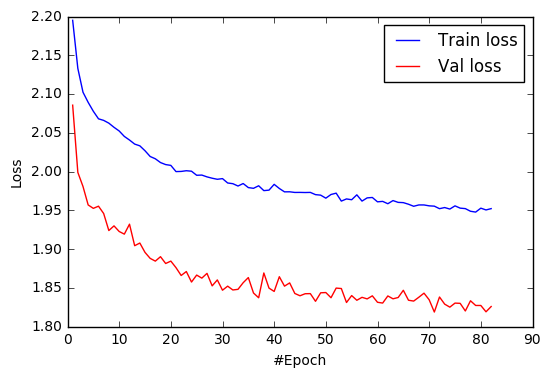

In [50]:
# data augmentation with Adam
base_model = gen_nn(adam=True)    
start = time.time()
%time aug_his = base_model.fit_generator(datagen.flow(X_train_grey, y_train, \
                    batch_size=batch_size), \
                    samples_per_epoch=X_train.shape[0], \
                    nb_epoch=nb_epoch, \
                    callbacks=[early_stop], \
                    verbose=0, \
                    validation_data=(X_valid_grey, y_valid))
# evaluate our model
score = base_model.evaluate(X_test_grey, y_test, verbose=0)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
plot_validation_history(aug_his, './output/fig-nn-val-aug.png')

CPU times: user 8min 32s, sys: 27.9 s, total: 9min
Wall time: 7min 16s

Test loss: 1.848
Test accuracy: 0.346


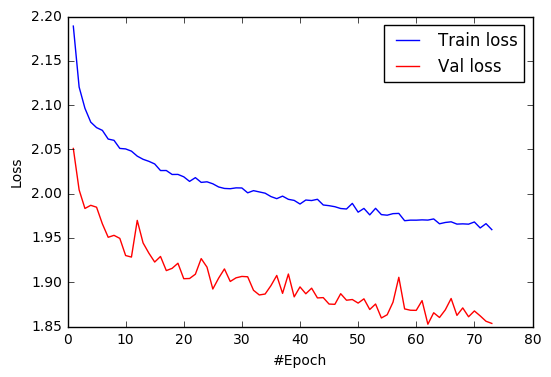

In [51]:
# data augmentation with Adam with clip_norm = 0.01
base_model = gen_nn(adam=True, clip_norm=True)    
start = time.time()
%time aug_his = base_model.fit_generator(datagen.flow(X_train_grey, y_train, \
                    batch_size=batch_size), \
                    samples_per_epoch=X_train.shape[0], \
                    nb_epoch=nb_epoch, \
                    callbacks=[early_stop], \
                    verbose=0, \
                    validation_data=(X_valid_grey, y_valid))
# evaluate our model
score = base_model.evaluate(X_test_grey, y_test, verbose=0)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
plot_validation_history(aug_his, './output/fig-nn-val-aug.png')

CPU times: user 3min 41s, sys: 11.7 s, total: 3min 53s
Wall time: 3min 10s

Test loss: 1.881
Test accuracy: 0.333


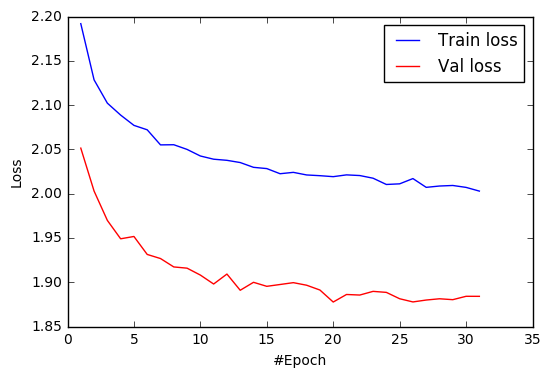

In [42]:
# data augmentation with Adam with clip_norm = 0.5
base_model = gen_nn(adam=True, clip_norm=True)    
start = time.time()
%time aug_his = base_model.fit_generator(datagen.flow(X_train_grey, y_train, \
                    batch_size=batch_size), \
                    samples_per_epoch=X_train.shape[0], \
                    nb_epoch=nb_epoch, \
                    callbacks=[early_stop], \
                    verbose=0, \
                    validation_data=(X_valid_grey, y_valid))
# evaluate our model
score = base_model.evaluate(X_test_grey, y_test, verbose=0)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
plot_validation_history(aug_his, './output/fig-nn-val-aug.png')

CPU times: user 8min 30s, sys: 27.7 s, total: 8min 57s
Wall time: 7min 13s

Test loss: 1.828
Test accuracy: 0.347


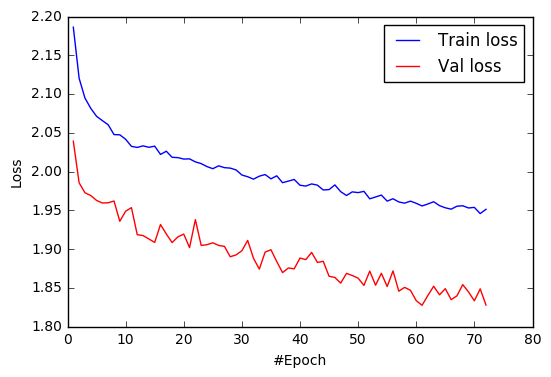

In [47]:
# data augmentation with Adam with clip_norm = 0.05
base_model = gen_nn(adam=True, clip_norm=True)    
start = time.time()
%time aug_his = base_model.fit_generator(datagen.flow(X_train_grey, y_train, \
                    batch_size=batch_size), \
                    samples_per_epoch=X_train.shape[0], \
                    nb_epoch=nb_epoch, \
                    callbacks=[early_stop], \
                    verbose=0, \
                    validation_data=(X_valid_grey, y_valid))
# evaluate our model
score = base_model.evaluate(X_test_grey, y_test, verbose=0)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
plot_validation_history(aug_his, './output/fig-nn-val-aug.png')

CPU times: user 11min 50s, sys: 37.9 s, total: 12min 27s
Wall time: 10min 4s

Test loss: 1.834
Test accuracy: 0.346


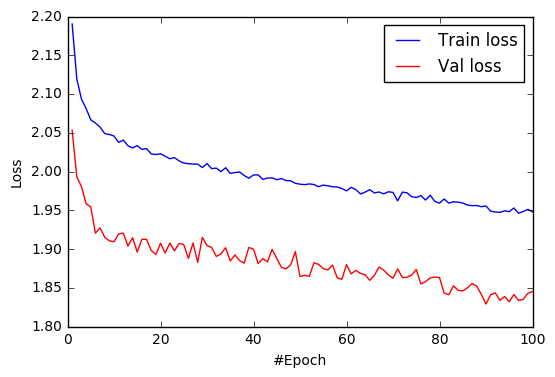

In [56]:
# data augmentation with Adam with clip_norm = 0.005
nb_epoch=100
base_model = gen_nn(adam=True, clip_norm=True)    
start = time.time()
%time aug_his = base_model.fit_generator(datagen.flow(X_train_grey, y_train, \
                    batch_size=batch_size), \
                    samples_per_epoch=X_train.shape[0], \
                    nb_epoch=nb_epoch, \
                    callbacks=[early_stop], \
                    verbose=0, \
                    validation_data=(X_valid_grey, y_valid))
# evaluate our model
score = base_model.evaluate(X_test_grey, y_test, verbose=0)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
plot_validation_history(aug_his, './output/fig-nn-val-aug.png')

CPU times: user 5min 16s, sys: 8.88 s, total: 5min 24s
Wall time: 4min 56s

Test loss: 1.675
Test accuracy: 0.407


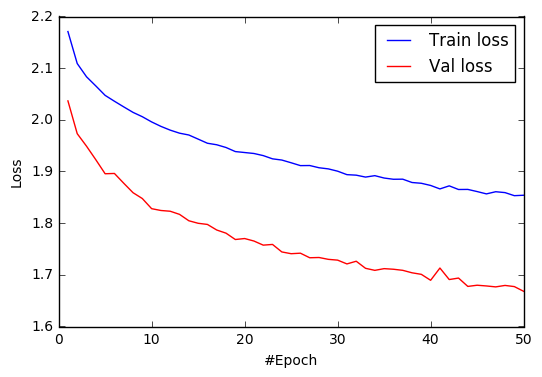

In [39]:
# data augmentation with Adam and low learning rate
base_model = gen_nn(adam=True, learning_rate=0.0001)    
start = time.time()
%time aug_his = base_model.fit_generator(datagen.flow(X_train_grey, y_train, \
                    batch_size=batch_size), \
                    samples_per_epoch=X_train.shape[0], \
                    nb_epoch=nb_epoch, \
                    callbacks=[early_stop], \
                    verbose=0, \
                    validation_data=(X_valid_grey, y_valid))
# evaluate our model
score = base_model.evaluate(X_test_grey, y_test, verbose=0)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
plot_validation_history(aug_his, './output/fig-nn-val-aug.png')

CPU times: user 10min 32s, sys: 17.2 s, total: 10min 49s
Wall time: 9min 54s

Test loss: 1.601
Test accuracy: 0.440


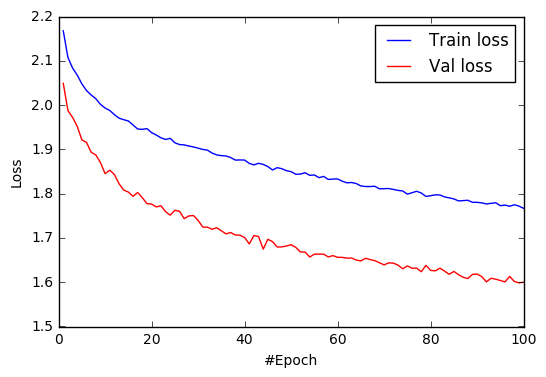

In [63]:
nb_epoch=100
# data augmentation with Adam and low learning rate
base_model = gen_nn(adam=True, learning_rate=0.0001)    
start = time.time()
%time aug_his = base_model.fit_generator(datagen.flow(X_train_grey, y_train, \
                    batch_size=batch_size), \
                    samples_per_epoch=X_train.shape[0], \
                    nb_epoch=nb_epoch, \
                    callbacks=[early_stop], \
                    verbose=0, \
                    validation_data=(X_valid_grey, y_valid))
# evaluate our model
score = base_model.evaluate(X_test_grey, y_test, verbose=0)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
plot_validation_history(aug_his, './output/fig-nn-val-aug.png')

data generator has a significant effect here!
Now, let's try to combine the differenct methods.

# data augmentation + batch normalization

CPU times: user 12min 6s, sys: 18 s, total: 12min 24s
Wall time: 11min 30s

Test loss: 1.494
Test accuracy: 0.479


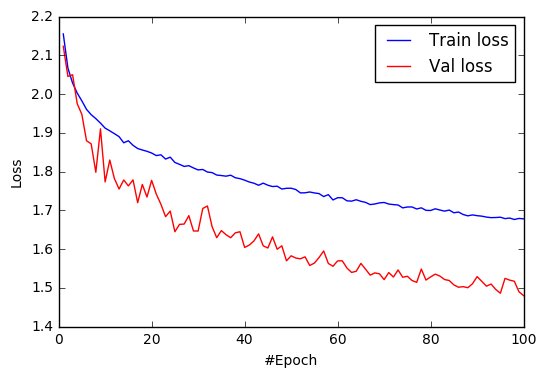

In [45]:
batch_norm_model = gen_nn(batch_normalization=True, adam=True)
%time aug_base_norm_his = batch_norm_model.fit_generator(datagen.flow(X_train_grey, y_train, \
                    batch_size=batch_size), \
                    samples_per_epoch=X_train_grey.shape[0], \
                    nb_epoch=nb_epoch, \
                    callbacks=[early_stop], \
                    verbose=0, \
                    validation_data=(X_valid_grey, y_valid))
# evaluate our model
score = batch_norm_model.evaluate(X_test_grey, y_test, verbose=0)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
plot_validation_history(aug_base_norm_his, './output/fig-nn-val-aug-batch-norm.png')

Here again we see that the learning curve is bouncing, let's try to apply gradeint clipping.

CPU times: user 13min 22s, sys: 37.3 s, total: 13min 59s
Wall time: 11min 41s

Test loss: 1.493
Test accuracy: 0.477


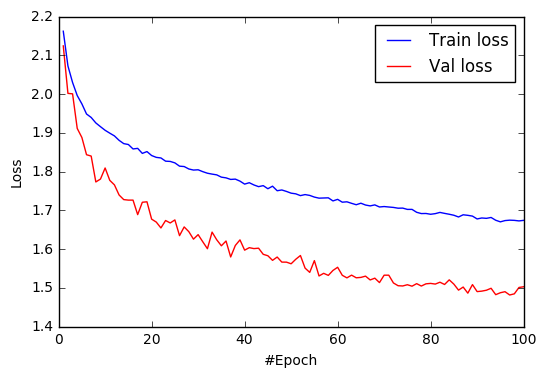

In [49]:
# clipnorm = 0.01
batch_norm_model = gen_nn(batch_normalization=True, adam=True, clip_norm=True)
%time aug_base_norm_his = batch_norm_model.fit_generator(datagen.flow(X_train_grey, y_train, \
                    batch_size=batch_size), \
                    samples_per_epoch=X_train_grey.shape[0], \
                    nb_epoch=nb_epoch, \
                    callbacks=[early_stop], \
                    verbose=0, \
                    validation_data=(X_valid_grey, y_valid))
# evaluate our model
score = batch_norm_model.evaluate(X_test_grey, y_test, verbose=0)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
plot_validation_history(aug_base_norm_his, './output/fig-nn-val-aug-batch-norm.png')

We can see that the learning curve has become smoother.

Now you've learned lots of techniques and layers to improve your model, good luck training!